The sole purpose of this file is to convert the CombinedCSI.mat file from the pipeline to a separate data.npy and mask.npy files for easier usage. You only have to insert the correct data folder name below and run the notebook. A CombinedCSI.mat file in that folder is required

In [ ]:
# import nibabel as nib
# import numpy as np
# import matplotlib.pyplot as plt

# # NIfTI laden
# nii = nib.load("Tumor_2/tumor_mask.nii")
# mask_data = nii.get_fdata()

# # In 0/1 Maske umwandeln
# mask_array = (mask_data > 0).astype(np.uint8)   # oder np.bool_ für bool-Maske

# mask_flipped = mask_array[::-1, ::-1, :] # muss x-y invertieren, .nii speichert das anders als CombinedCSI.mat

# head_mask = np.load("Tumor_2/mask.npy")
# mask_flipped = mask_flipped*head_mask

# # np.save('Tumor_2/tumor_mask.npy', mask_flipped)
# # np.save('Tumor_2_normalized/tumor_mask.npy', mask_flipped)

# print(mask_array.shape, mask_array.dtype)

(22, 22, 21) uint8


In [2]:
mask = np.load('Tumor_1/mask.npy')

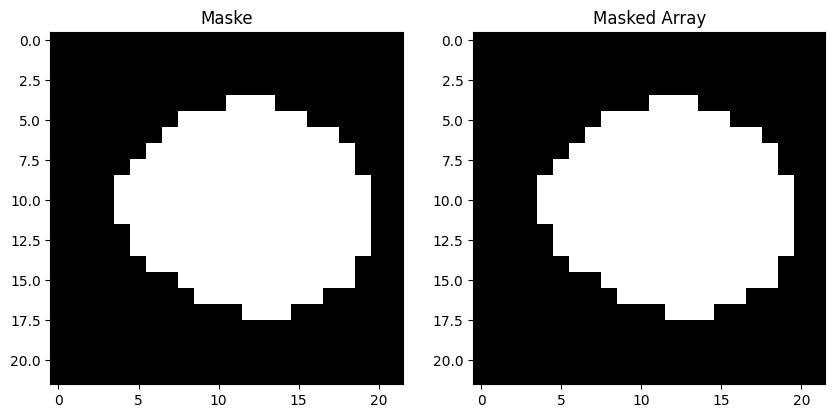

In [6]:
import matplotlib.pyplot as plt

z = 14

slice_mask = mask_flipped[..., z]          # deine Maske
slice_masked = mask[..., z]      # dein anderes Array, gleiche Werte

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(slice_mask, cmap="gray")
axes[0].set_title("Maske")

axes[1].imshow(slice_masked, cmap="gray")
axes[1].set_title("Masked Array")

plt.show()

In [1]:
def low_rank_5d(data, rank):
    """
    Computes a low-rank decomposition of a tensor with shape (22, 22, 21, 96, 8)
    using truncated SVD.

    Args:
        data (np.ndarray): Numpy array of shape (x, y, z, t, T).
        rank (int): The number of singular values to keep (final rank).

    Returns:
        np.ndarray: The reconstructed tensor with rank 'rank'.
    """

    # Unpack dimensions
    x, y, z, t, T = data.shape
    
    # Reshape the 5D tensor into a 2D matrix of shape (x*y*z, t*T)
    # Use 'F' (Fortran) order to match MATLAB's column-major ordering
    reshaped_matrix = data.reshape((x * y * z * T, t), order='F')
    
    # Perform economy-size SVD (similar to MATLAB's "svd(..., 'econ')")
    U, singular_values, Vh = np.linalg.svd(reshaped_matrix, full_matrices=False)
    
    # Truncate the singular values to the desired rank
    k = min(rank, len(singular_values))  # safeguard: rank cannot exceed # of singular values
    singular_values_truncated = np.zeros_like(singular_values)
    singular_values_truncated[:k] = singular_values[:k]
    
    # Form the diagonal matrix of truncated singular values
    S_truncated = np.diag(singular_values_truncated)
    
    # Reconstruct the matrix using the truncated SVD components
    reconstructed_matrix = U @ S_truncated @ Vh
    
    # Reshape back to the original 5D shape, again using 'F' order
    reconstructed_tensor = reconstructed_matrix.reshape((x, y, z, t, T), order='F')
    
    return reconstructed_tensor

In [1]:
data_folder_name = "Simulated_1"

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

#### load matlab data ####
data = loadmat(f'{data_folder_name}/B0_1.mat')
Daten = data['csi_data_lr']['Data'][0,0]

Daten_fft = np.fft.ifftshift(np.fft.fft(np.fft.fftshift(Daten, axes=-2), axis=-2), axes=-2)

In [2]:
data = np.load('Simulated_Lesion_GT/data.npy')

data_fft = np.fft.ifftshift(np.fft.fft(np.fft.fftshift(data, axes=-2), axis=-2), axes=-2)

In [ ]:
def build_basis(noisy: np.ndarray, rank: int):
    # noisy: (x, y, z, t, T)
    # bring t ans Ende, damit reshape((…, t)) t-dimension isoliert
    noisy2 = noisy.transpose(0, 1, 2, 4, 3)  # jetzt (x, y, z, T, t)
    x, y, z, T, t = noisy2.shape

    # flatten spatial+T zu Zeilen, Spektrum als Spalten
    M = noisy2.reshape((x * y * z * T, t), order='F')

    # SVD auf jeder Zeile = Spektrum
    U, S, Vh = np.linalg.svd(M, full_matrices=False)

    # Vh[:rank] sind die Top-r rechten Singularvektoren (in R^t)
    V_r = Vh[:rank].conj().T   # (t, rank)

    return V_r, S[:rank]

def project(data: np.ndarray, V_r: np.ndarray):
    # data: (x, y, z, t, T), V_r: (t, rank)
    data2 = data.transpose(0, 1, 2, 4, 3)     # (x,y,z,T,t)
    x, y, z, T, t = data2.shape

    M = data2.reshape((x*y*z*T, t), order='F')   # (N, t)
    C = M @ V_r                                 # (N, rank)
    R = C @ V_r.conj().T                        # (N, t)
    recon = R.reshape((x, y, z, T, t), order='F')\
               .transpose(0,1,2,4,3)            # zurück zu (x,y,z,t,T)

    return recon, C

# 1. Basis aus noisy_data bauen (Rank 8)

rank = 20

V_r, S_r = build_basis(data, rank=rank)     # V_r: (t, 8), S_r: (8,)

data_2 = np.load('Simulated_Lesion_1/data.npy')

data_2_LR8, _ = project(data_2,V_r)

np.save(f"basis_rank{rank}.npy", V_r)       

In [20]:
data_2_LR8.shape

(22, 22, 21, 120, 8)

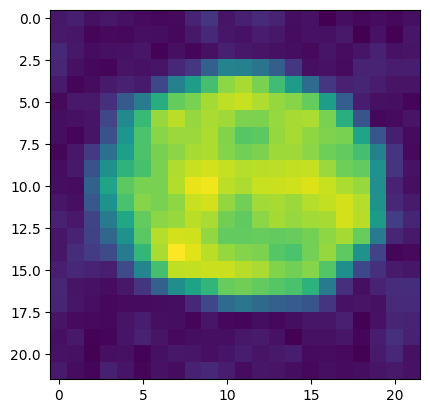

In [21]:
z, t, T = 10, 1, 5

Slice = np.abs(data_2_LR8)[:,:,z,t,T ]

plt.imshow(Slice)

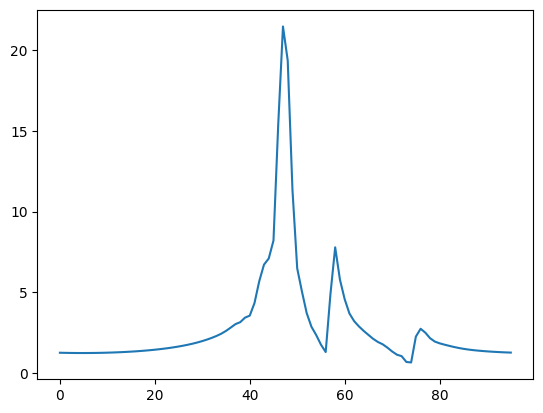

In [29]:
x,y,z,T = 8,12,10,2

Line = np.abs(Daten_fft)[x,y,z,:,T]

plt.plot(Line)

In [3]:
data.shape

AttributeError: 'dict' object has no attribute 'shape'

In [ ]:
data_folder_name = "P08_LR8"

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

#### load matlab data ####
data = loadmat(f'{data_folder_name}/CombinedCSI.mat')
Daten = data['csi']['Data'][0,0]
#Daten = low_rank_5d(Daten, 8)

mask = data['mask']

#### save data as numpy arrays ####
np.save(f'{data_folder_name}/data.npy', Daten)
np.save(f'{data_folder_name}/mask.npy', mask)



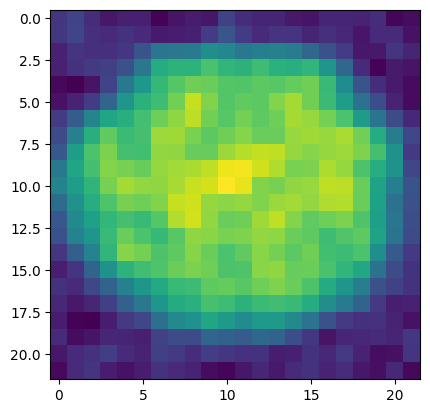

In [4]:
data = np.load(f'{data_folder_name}/data.npy')

z,t,T = 10,1,7

Slice = np.abs(Daten)[:,:,z,t,T]

plt.imshow(Slice)

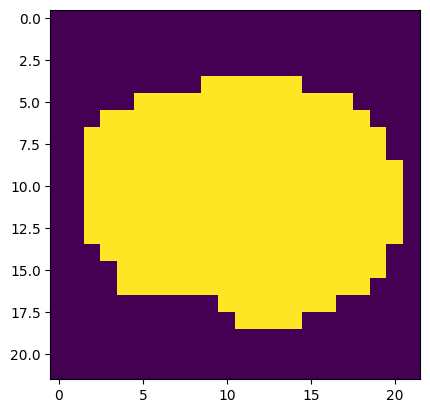

In [4]:
mask = np.load(f'{data_folder_name}/mask.npy')

z,t,T = 10,1,7

Slice = np.abs(mask)[:,:,z]

plt.imshow(Slice)